# Twitter Analysis for # INDvAUS which was Trending No.1 in HYD

### Import Modules

All modules required can be installed via requirements.txt included in the same folder

In [20]:
import sys
import tweepy
import json
import re
from textblob import TextBlob
from wordcloud import WordCloud, STOPWORDS
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx
from operator import itemgetter
from scipy import stats
%matplotlib inline

### Preparing the data from tweets.json

"tweets.json" file has the 10K Tweets collected on the hashtag #INDvAUS on 17th December 2020 when it was trending in Hyderabad. The tweets were collected from around the globe because of the limitations with the Twitter API. The Twitter API Documentation mentions that the Search API is not exhaustive and will not return the exhaustive list of tweets. Due to these limitation I collected Tweets from around the globe using the Streaming API of Twitter. I used the python package Tweepy to interface with twitter API Programmatically in python. "tweets.json" has 10k tweets in each line in json format. The "twitter.py" file in this repo is used to collect the 10K Tweets and is well-commented for explanation.

In [21]:
all_tweets=[]
count_links=0
tweet_text=""
all_hashtags=set()
top_langs=[]
top_langs_numbers=[]
lang=set()
verified=0
langs={}
video=0
photo=0
gif=0
with open("./tweets.json") as f:
    all_tweets.clear()
    count=0
    for jsonstring in f:
        if '"type": "video"' in jsonstring:
            video+=1
        if '"type": "photo"' in jsonstring:
            photo+=1
        if '"type": "GIF"' in jsonstring:
            gif+=1
        jsonobj = json.loads(jsonstring)
        dict={}
        dict['text']=jsonobj['text']
        if "https" in dict['text'] or "http" in dict['text'] :
            count_links+=1
        tweet_text= tweet_text + ' '.join(re.sub("(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)", " ",jsonobj['text']).split())
        dict['clean_text']=' '.join(re.sub("(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)", " ",dict['text']).split())
        dict['devices']=jsonobj['source']
        dict['in_reply_to_status_id']=jsonobj['in_reply_to_status_id']
        dict['verified']=jsonobj['user']['verified']
        lang= jsonobj['lang']
        if lang != "und":
            if lang in langs:
                langs[lang]+=1
            else:
                langs[lang]=1
        if dict['verified']== True:
            verified+=1
        dict['followers_count']=jsonobj['user']['followers_count']
        dict['listed_count']=jsonobj['user']['listed_count']
        dict['hashtags']=[hashes['text'] for hashes in jsonobj['entities']['hashtags']]
        all_tweets.append(dict)
    for tweet in all_tweets:
        for hashtag in tweet['hashtags']:
            all_hashtags.add(hashtag)
    langs={k: v for k, v in sorted(langs.items(), key=lambda item: item[1], reverse=True)}
    for lang,langcount in langs.items():
        top_langs.append(lang)
        top_langs_numbers.append(langcount)
    
        
    
    

# What can we say about the users who tweeted this hashtag? - Sentiment Analysis
    

Firstly, I decided to find out what can we say about the opinions posted by the users from which I collected the 10K Tweets. For this I decided to analyse the emotions present in the Text of the Tweets. For this I used the Python Library TextBlob to do Sentiment Analysis on the Collected Tweets and used matplotlib's plot to plot a Pie Chart. Analysis is given below. These user's are Cricket fans.

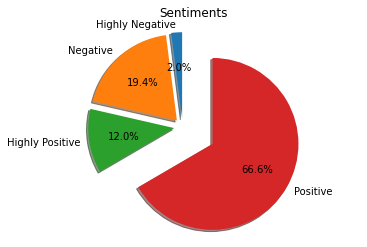

In [28]:
# Here we use the TextBlob Library Available on Python
highly_negative=0
negative=0
neutral=0
positive=0
highly_positive=0
for tweet in all_tweets:
    analysis = TextBlob(tweet['clean_text'])
    if analysis.sentiment.polarity==0:
        neutral+=1
    elif analysis.sentiment.polarity > 0.5 and analysis.sentiment.polarity <=1:
        highly_positive+=1
    elif analysis.sentiment.polarity <= 0.5 and analysis.sentiment.polarity > 0:
        positive+=1
    elif analysis.sentiment.polarity < 0 and analysis.sentiment.polarity >= -0.5:
        negative+=1
    elif analysis.sentiment.polarity < -0.5 and analysis.sentiment.polarity >= -1:
        highly_negative+=1
        
labels = ['Highly Negative', 'Negative', 'Highly Positive', 'Positive']
sizes = [highly_negative, negative , highly_positive , positive]
explode = (0.1, 0.1, 0.1, 0.4)

fig, ax = plt.subplots()
ax.pie(sizes,
       explode=explode,
       labels=labels,
       autopct='%1.1f%%',
       shadow=True,
       startangle=90)
ax.axis('equal')
ax.set_title('Sentiments')


plt.show()
    
        
    


### Analysis of Sentiment Analysis Pie Chart ( Fig.1 )
The tweets were collected on 17th December 2020 in the morning. The general tendency of the tweets were to be of Positive (66%), Highly Positive (12%), Negative (19.4%) and rest highly negative. 


# Can we draw any insights about their user’s followers and friends?
This was an interesting piece to analyse. There are three types of interactions between two Twitter users that we should gather: retweets, replies, and mentions. For this we plot a graph of these interactions. An edge exists in the graph if there has been an interaction between these users. For this I used the networkx library in python to analyse the network graph. 

In [4]:
tweets_df = pd.read_json("tweets.json", lines=True) # we load the data into a pandas data frame. 
# This is useful as each JSON is new line after it has been generated from twitter.py
pd.set_option('display.float_format', lambda x: '%.f' % x)
# here we define the coloumns of the dataframe.. Collecting useful info
tweets_final = pd.DataFrame(columns = ["created_at", "id", "in_reply_to_screen_name", "in_reply_to_status_id", "in_reply_to_user_id",
                                      "retweeted_id", "retweeted_screen_name", "user_mentions_screen_name", "user_mentions_id", 
                                       "text", "user_id", "screen_name", "followers_count"])
equal_columns = ["created_at", "id", "text"]
# copy all relevent data
tweets_final[equal_columns] = tweets_df[equal_columns]
tweets_final["screen_name"] = tweets_df["user"].apply(lambda x: x["screen_name"])
tweets_final["user_id"] = tweets_df["user"].apply(lambda x: x["id"])
tweets_final["followers_count"] = tweets_df["user"].apply(lambda x: x["followers_count"])
tweets_final["user_mentions_screen_name"] = tweets_df["entities"].apply(lambda x: x["user_mentions"][0]["screen_name"] if x["user_mentions"] else np.nan)
tweets_final["user_mentions_id"] = tweets_df["entities"].apply(lambda x: x["user_mentions"][0]["id_str"] if x["user_mentions"] else np.nan)
tweets_final["retweeted_screen_name"] = tweets_df["retweeted_status"].apply(lambda x: x["user"]["screen_name"] if x is not np.nan else np.nan)
tweets_final["retweeted_id"] = tweets_df["retweeted_status"].apply(lambda x: x["user"]["id_str"] if x is not np.nan else np.nan)
tweets_final["in_reply_to_screen_name"] = tweets_df["in_reply_to_screen_name"]
tweets_final["in_reply_to_status_id"] = tweets_df["in_reply_to_status_id"]
tweets_final["in_reply_to_user_id"]= tweets_df["in_reply_to_user_id"]
tweets_final = tweets_final.where((pd.notnull(tweets_final)), None)
graph = nx.Graph()

# This function gets the interaction between the users. 
# Function that will iterate over the DataFrame, obtain the user_id and screen_name of the user that the author of 
# that specific tweet mention, reply or retweet. The function will return the user of the specific tweet together 
# with a list of the users with whom the user interacted.
def get_interactions(row):
    user = row["user_id"], row["screen_name"]
    if user[0] is None:
        return (None, None), []
    interactions = set()
    interactions.add((row["in_reply_to_user_id"], row["in_reply_to_screen_name"]))
    interactions.add((row["retweeted_id"], row["retweeted_screen_name"]))
    interactions.add((row["user_mentions_id"], row["user_mentions_screen_name"]))
    interactions.discard((row["user_id"], row["screen_name"]))
    interactions.discard((None, None))
    return user, interactions

# Here we loop through the all tweets and call the get_interactions function to get the interactions.
# Then we build the graph.
for index, tweet in tweets_final.iterrows():
    user, interactions = get_interactions(tweet)
    user_id, user_name = user
    tweet_id = tweet["id"]
    for interaction in interactions:
        int_id, int_name = interaction
        graph.add_edge(user_id, int_id, tweet_id=tweet_id)
        graph.nodes[user_id]["name"] = user_name
        graph.nodes[int_id]["name"] = int_name
print(f"There are {graph.number_of_nodes()} Users and {graph.number_of_edges()} Interactions present in the Network")
degrees = [val for (node, val) in graph.degree()]
max_degrees=np.max(degrees)
min_degrees=np.min(degrees)
print(f"The Maximum Interaction in the Network is {max_degrees}")
print(f"The Minimum Interaction in the Network is {min_degrees}")
max_nodes=[node for (node, val) in graph.degree() if val==max_degrees]
print("The maximum Interaction is by Following Users: ",max_nodes)
print(f"The Average Level of Interaction in the Network is {np.mean(degrees):.1f}") 
print(f"There are {nx.number_connected_components(graph)} Connected Social Groups in the Network")
largest_subgraph = list(graph.subgraph(c) for c in nx.connected_components(graph))[0]
print(f"There are {largest_subgraph.number_of_nodes()} nodes and {largest_subgraph.number_of_edges()} \
edges present in the largest social group")
print(f"The average clustering coefficient is {nx.average_clustering(largest_subgraph)} in the largest subgraph")
print(f"The transitivity of the largest subgraph is {nx.transitivity(largest_subgraph)}")
    

There are 5281 Users and 5841 Interactions present in the Network
The Maximum Interaction in the Network is 553
The Minimum Interaction in the Network is 1
The maximum Interaction is by Following Users:  ['1098141150144356352']
The Average Level of Interaction in the Network is 2.2
There are 426 Connected Social Groups in the Network
There are 4071 nodes and 5055 edges present in the largest social group
The average clustering coefficient is 0.00030295586669941866 in the largest subgraph
The transitivity of the largest subgraph is 9.30558614336186e-06


In [5]:
print(f"The Biggest Distance Between two Users in the network is {nx.diameter(largest_subgraph)}")
print(f"The Average Distance between any two Users is {nx.average_shortest_path_length(largest_subgraph):.2f}")
graph_centrality = nx.degree_centrality(largest_subgraph)
max_de = max(graph_centrality.items(), key=itemgetter(1))
graph_closeness = nx.closeness_centrality(largest_subgraph)
max_clo = max(graph_closeness.items(), key=itemgetter(1))
graph_betweenness = nx.betweenness_centrality(largest_subgraph, normalized=True, endpoints=False)
max_bet = max(graph_betweenness.items(), key=itemgetter(1))
print(f"The User with id {max_de[0]} has a degree centrality of {max_de[1]:.2f} which is the maximum in the network")
print(f"The User with id {max_clo[0]} has a closeness centrality of {max_clo[1]:.2f} which is the maximum in the network")
print(f"The User with id {max_bet[0]} has a betweenness centrality of {max_bet[1]:.2f} which is the maximum in the network")

The Biggest Distance Between two Users in the network is 19
The Average Distance between any two Users is 6.35
The User with id 1098141150144356352 has a degree centrality of 0.14 which is the maximum in the network
The User with id 1098141150144356352 has a closeness centrality of 0.28 which is the maximum in the network
The User with id 1098141150144356352 has a betweenness centrality of 0.54 which is the maximum in the network


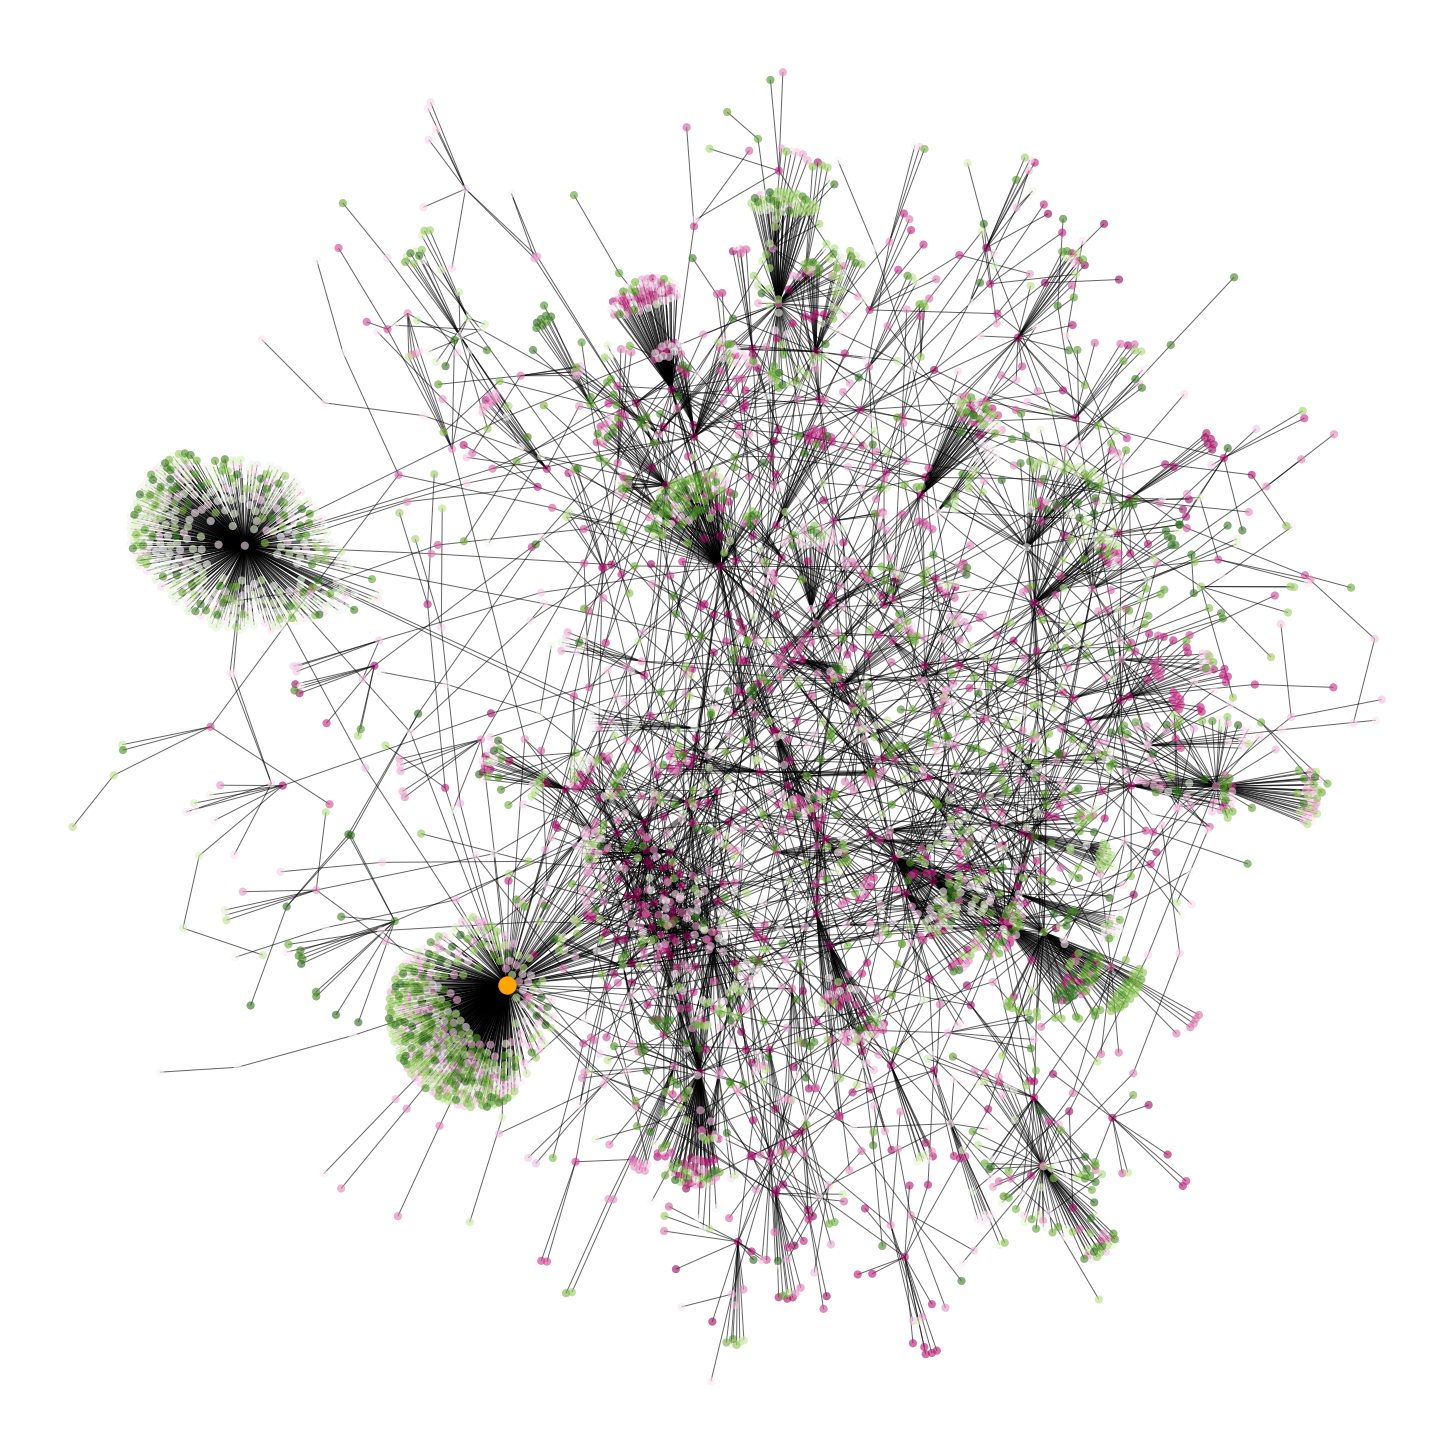

In [6]:
node_and_degree = largest_subgraph.degree()
colors_central_nodes = ['orange']
central_nodes = ['1098141150144356352']
pos = nx.spring_layout(largest_subgraph, k=0.05)
plt.figure(figsize = (20,20))
nx.draw(largest_subgraph, pos=pos, node_color=range(4071), cmap=plt.cm.PiYG, edge_color="black", linewidths=0.3, node_size=60, alpha=0.6, with_labels=False)
nx.draw_networkx_nodes(largest_subgraph, pos=pos, nodelist=central_nodes, node_size=300, node_color=colors_central_nodes)
plt.show()

### Fig.2  The Largest Connected Social Group in the Network
From the tweets collected I was able to analyse the networking of 5281 Users and 5841 Interactions ( retweets, replies, mentions). The maximum interaction shown by a user in the data collected is 553 interactions and is by twitter user with id: 1098141150144356352. On checking this is none other than user [@WasimJaffer14](https://twitter.com/WasimJaffer14?ref_src=twsrc%5Egoogle%7Ctwcamp%5Eserp%7Ctwgr%5Eauthor). This is the twitter account of the Former India Cricketer  [Wasim Jaffer](https://en.wikipedia.org/wiki/Wasim_Jaffer). He is orange in graph.The average level of interaction in the network is 2.2 which means there was about 2 connections between two users in terms of replies, retweets, mention etc. There was 426 Connected Social Groups in the Network (connected component in graph). The largest one has Wasim as the centre with 4071 nodes and 5055 edges present in it. We can easily tell that this is the series of retweets, replies, , mentions etc to the famous celebraties tweets, and from the plot we can also tell that there are many small groups of friends interacting with each other and that whole group interaction with Wasim. Wasim Jaffer has been very active in his tweets during this match and has posted some viral tweets. Then on further calculation of Clustering Coefficient and Transitivity of the graph we can find how closely knit the community of tweets connected were. The whole community is connected by the Spirit of Cricket. On calculating the largest distance between two users ( diameter of the largest component ) we find that it took 19 interactions to connect two users at the worst. This means two users were connected by 19 interactions or less in this largest component centered around Wasim. And also the average interactions required to connect two users turns out to be 6.35 . All the centralities lies around Wasim for this component which is no brainer.

![Wasim Jaffer](images/1.png)
The orange dot is Wasim
![Friends Community](images/2.png)
This is a friends community that is getting connected to Wasim making him the centre of one of the biggest components in the network.



# Can we comment on the language aspect of the corpus collected?

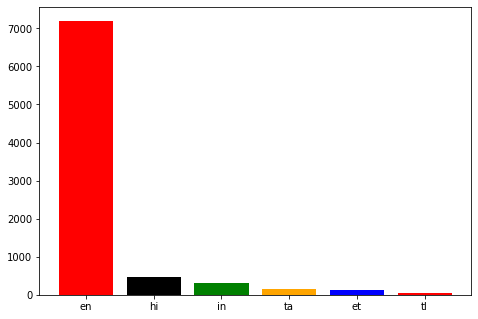

In [23]:
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.bar(top_langs[:6],top_langs_numbers[:6],color=['red', 'black', 'green', 'orange', 'blue'])
plt.show()


### Fig 3. No. of Tweets vs Top Languages
Next on Analysis of the language of used in the tweets collected, We see that English is one of the main languages used, but it is worth noting that twitter does not recognise native languages written in English in cases Hindi seems to be an exception ) and sometimes has false info reagrding languages. But by not considering these as the number differences are very large, we see that Hindi and English dominates. English is understandable and I think Hindi can be explained by the countries involved in the match Australia and India. The languages are represented in the plot as codes from Twitter

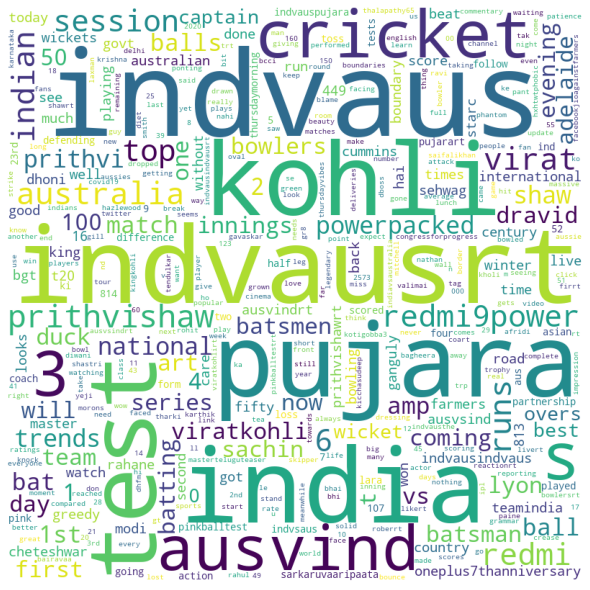

In [25]:
comment_words = ' '
stopwords = set(STOPWORDS) 
tokens = tweet_text.split()
for i in range(len(tokens)): 
    tokens[i] = tokens[i].lower()
for words in tokens: 
    if words not in stopwords: 
        comment_words = comment_words + words + ' '
counts = {}
for word in comment_words.split():
    if word in counts:
        counts[word] += 1
    else:
        counts[word] = 1
wordcloud = WordCloud(width = 800, height = 800, 
                background_color ='white', 
                max_words=1000,
                relative_scaling=0.21,
                stopwords = stopwords, 
                min_font_size = 10).generate_from_frequencies(counts)
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 

plt.show()

### Fig 4. Word Cloud Analysis
Next on Generating the Word Cloud on the tweet text using worldcloud python libaray. We find the commonly used words in text. It is not a surprise to see Pujara, the hastag itself, India, Kohli, dravid etc. But what came as a surprise is words like Modi, thalapathy65, oneplus7, redmi etc. On further checking the tweets collected the usage of unrelated hashtags like modi, thalapathy65, oneplus7, redmi etc are twitter tactics to reach more audience by using irrelavant hashtags. Also some of the tweets were also critical of the Modi Government and the farmers issue. Some to me seem just spam Advertisement where they are just using trending hashtags. Also oneplus7thanniversary and redmi was also trending at that time in other parts of the world. So spammers were using it to increase reach. Rest of the words in the word cloud makes sense.

Looking at events that took place during this time period during the match like
- 09: 00 IST: India skipper Virat Kohli wins toss and elects to bat first.
- 09: 25 IST: Prithvi Shaw will be under the spotlight as soon as he comes out to bat alongside Mayank Agarwal.
- 09: 33 IST: WICKET! Dream start for Australia as Prithvi Shaw departs for a 2-ball duck. Mitchell Starc draws first blood for the Aussies as Shaw's rough patch continues.
- 11: 02 IST: WICKET! Pat Cummins comes gets his first wicket of the match after the drinks break and gets rid of Mayank Agarwal.
- 12: 12 IST: Virat Kohli and Cheteshwar Pujara are back on the pitch to start off the second session.
- 13: 55 IST: Cheteshwar Pujara departs just as India reach 100-run mark.
- 14: 13 IST: Nathan Lyon continues from one end of the pitch while Marnus Labuschagne has also been brought into the attack by skipper Tim Paine.
- 14:53 IST: Fifty for Virat Kohli! 

etc helps us in making sense of the rest of the Word Cloud, but the spamming is of real concern here.


## Some other Observations

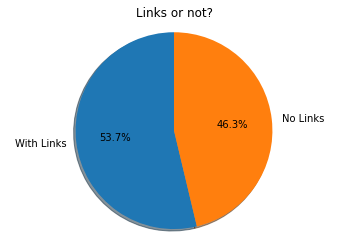

In [26]:
labels = ['With Links', 'No Links']
sizes = [count_links, len(all_tweets)-count_links]

fig, ax = plt.subplots()
ax.pie(sizes,
       labels=labels,
       autopct='%1.1f%%',
       shadow=True,
       startangle=90)
ax.axis('equal')
ax.set_title('Links or not?')


plt.show()

### Fig 5. The distribution of tweets with links and without links
More than half of the tweets contain somekind of link to an external webpage. This might be because this trending hashtag was used for marketing by many people

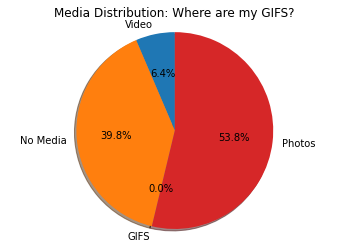

In [27]:
labels = [  'Video', "No Media",'GIFS','Photos']
sizes = [video, len(all_tweets)-video-gif-photo,gif,photo]

fig, ax = plt.subplots()
ax.pie(sizes,
       labels=labels,
       autopct='%1.1f%%',
       shadow=True,
       startangle=90)
ax.axis('equal')
ax.set_title('Media Distribution: Where are my GIFS?')


plt.show()

### Fig 6. The media distribution in tweets
We all love consuming media, and it really shows... More than half of the tweets have an image with them, followed by some amount of video. But it is worth noting that there is no tweet with a GIF. 